In [358]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [463]:
df = pd.read_excel("base_a_traiter.xlsx")
df = df[df["Compagnie"] != "SNCF"]
df["Month"] = df["Date_aller"].apply(lambda date:date.month)  # On crée de nouvelles variables qui feront partie des variabls explicatives des modèles de régression
df["Week"] = df["Date_aller"].apply(lambda date:date.week)
n = int(0.4*len(df.sort_values("Prix")))       # On ne prend pas en compte les valeurs de prix extrêmes qui peuvent biaiser nos prédictions
df = df.sort_values("Prix").iloc[:n]

# Preprocessing

<ipython-input-464-2fc886fee4d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg["y_standard"] = preprocessing.scale(df_reg["Prix"]) # On transforme la variable "Prix" de sorte à ce que sa loi soit la loi normale centrée réduite


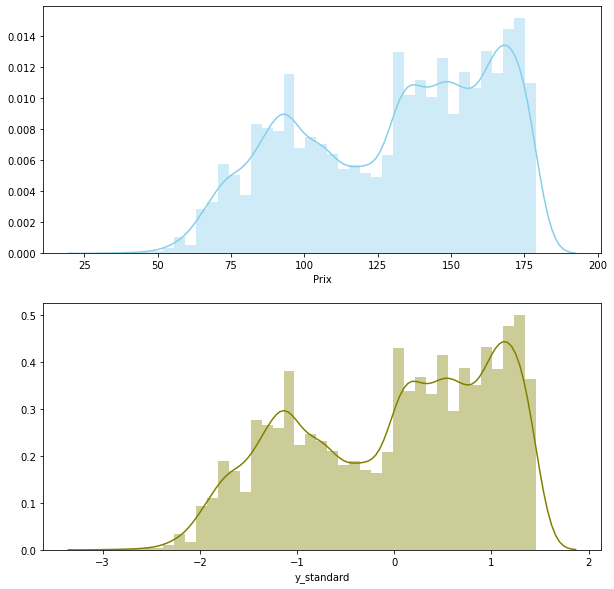

In [464]:
from sklearn import preprocessing
xvars = ["Distance", "Total d'escales", "Duree de vol", "Month", "Week", "Compagnie"] # Variables explicatives
df_reg = df[["Prix"] + xvars]
df_reg["y_standard"] = preprocessing.scale(df_reg["Prix"]) # On transforme la variable "Prix" de sorte à ce que sa loi soit la loi normale centrée réduite
df_reg.dropna(how = "any")
f, axes = plt.subplots(2, figsize=(10, 10))
sns.distplot(df_reg["Prix"] , color="skyblue", ax=axes[0])
sns.distplot(df_reg["y_standard"] , color="olive", ax=axes[1]) # On vérifie que la distribution de la variable "y_standard" est centrée et que sa variance empirique vaut 1

In [465]:
df_regb = df[xvars].drop(columns = ["Compagnie", "Week", "Month"]) # On conserve les variables quantitatives
indices_to_keep = ~df_regb.isin([np.inf, -np.inf]).any(axis = 1)
df_regb = df_regb[indices_to_keep].astype(np.float64)
scaler = preprocessing.StandardScaler().fit(df_regb) 
X1 = scaler.transform(df_regb) # On applique le Transformer Scaler qui transforme nos données empiriques de sorte à ce que leur moyenne vaille 0 et leur variance vaille 1

In [466]:
X2 = pd.get_dummies(df["Compagnie"]) # On transforme la variable "Compagnie" en variables indicatrices pour chaque compagnie de vol
X2 = np.array(X2)
n2 = np.shape(X2)[1] - 1
X2 = X2[:,:n2]
X = np.concatenate((X1,X2), axis=1)

In [467]:
X3 = pd.get_dummies(df["Week"]) 
X3 = np.array(X3)
n3 = np.shape(X3)[1] - 1
X3 = X3[:,:n3]
X = np.concatenate((X, X3), axis = 1)

In [468]:
X4 = pd.get_dummies(df["Month"])
X4 = np.array(X4)
n4 = np.shape(X4)[1] - 1
X4 = X2[:,:n4]
X = np.concatenate((X, X4), axis = 1)

# Régression linéaire

In [469]:
X_train, X_test, y_train, y_test = train_test_split(X, df_reg[["y_standard"]].values.ravel(), test_size = 0.3, random_state = 0) # On répartit nos données en base d’apprentissage et de test
ols = LinearRegression().fit(X_train, y_train) # On applique le modèle de régression linéaire aux données standardisées
y_pred = ols.predict(X_test)
print(ols.intercept_, ols.coef_)

-0.5830051950913671 [ 2.02399367e-01  3.79836512e-01 -1.18868158e-01  6.62118819e+11
 -3.80622684e+11 -1.90617733e+11 -3.57194729e+11 -5.41628372e+11
  9.79120160e-01  9.98897076e-01  4.21154976e-01  3.08776855e-01
  1.06348562e+00  7.47840881e-01  8.93247604e-01  1.23226929e+00
  3.32134247e-01  3.72436523e-01  6.74987793e-01  6.88415527e-01
  4.32824135e-01  8.67797852e-01  1.32804728e+00  6.53549194e-01
 -3.63723755e-01  1.14923096e+00  5.55999756e-01  7.63259888e-01
 -3.59558105e-01  4.94384766e-02  9.47425842e-01  3.73072565e-01
  5.85998535e-01  1.11695004e+00  2.88301468e-01 -3.88519287e-01
  2.10700035e-02  1.03816986e-02 -1.40220642e-01 -1.13090515e-01
 -3.76586914e-02  8.39233398e-03 -1.63276672e-01  1.29203796e-01
  9.42993164e-03  7.35244751e-02  1.18827820e-01  2.45193481e-01
  5.38824320e-01  5.26607513e-01  5.64254761e-01  6.25052452e-01
  5.60638428e-01  3.97670746e-01  4.02496338e-01  4.84924316e-01
  4.05181885e-01  1.15112305e-01  1.34521484e-01 -6.62118819e+11
  3.8

In [470]:
mse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
r = sklearn.metrics.r2_score(y_test, y_pred)
print("Mean squared error: %.2f" % mse)
print("Coefficient of Pearson's linear determination: %.2f" % r)

Mean squared error: 0.76
Coefficient of Pearson's linear determination: 0.42


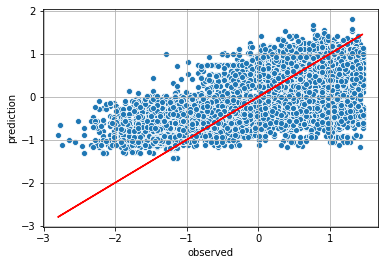

In [471]:
fig = plt.figure()
axes = plt.axes()
axes.grid()
tempdf = pd.DataFrame({"prediction": y_pred, "observed": y_test, "error": y_test - y_pred})
sns.scatterplot(data = tempdf, x = "observed", y = "prediction")
plt.plot(y_test,y_test,'r') # On regarde la concentration des prédictions autout de la première bissectrice
# Plus le coefficient de détermination linéaire de Pearson sera proche de 1 et plus les points seront concentrées autour de la droite

# Régression Logistique



In [475]:
df_reg['y'] = (df_reg["y_standard"] > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, df_reg[["y"]].values.ravel(), test_size = 0.2, random_state = 0)
clf = LogisticRegression().fit(X_train, y_train) # On applique lemodèle de régression logistique aux données standardisées
y_pred = clf.predict(X_test)
print(clf.intercept_, clf.coef_)

<ipython-input-475-fb05a60e89a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['y'] = (df_reg["y_standard"] > 0.5).astype(int)


[-1.08345482] [[ 0.34725319  0.91721048 -0.38556765  1.52760794  0.90081616  0.99179547
   0.42048092  1.06629297  1.86656336  1.99317589 -0.07962802 -0.30090672
   2.24350233  0.88130491  2.47382521  1.97952128 -0.14117746  0.54036431
   0.59666244  0.57622624 -0.41941952  1.53529785  2.29196611  0.82630729
  -1.23439995  2.18476393  0.24594837  0.91759157 -1.17989498 -0.07728341
   3.75148633  0.10218721  0.81214121  2.14932201  0.88992422 -2.66884672
  -0.40747303 -0.29163971  0.19122494 -0.13917429 -0.5870241  -0.5904003
  -0.30115606 -0.29516689 -0.30868671 -0.27767218  0.04821248  0.06237977
   0.64258451  0.43386008  0.5991405   0.79118546  0.69625617  0.34692826
   0.47208948  0.6451174   0.77766467  0.12378782  0.34148852  1.52760794
   0.90081616  0.99179547  0.42048092  1.06629297]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7369947126044687
0.6371764705882352
0.686960933536276
0.5941202281702501


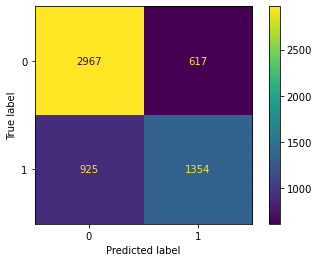

In [476]:
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test) # On affiche la matrice de confusion du modèle

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

print(sc_accuracy) # On affiche une mesure de la qualité de prédiction du modèle 
print(sc_f1)
print(sc_recall)
print(sc_precision)